# Approximating data using deep learning

Note that for this approach we based ourselves on the Standford lecture notes on convolutional neural networks for visual recognition.

This lecture is open source and can be found on http://cs231n.github.io/ 

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2

import gc

import crowd

import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.9

In [3]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err
    
    
def build_poly(X, degree):
    poly = np.ones((len(X), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(X, deg)]
    return poly[:, 1:]

def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def plot_history(history):
    '''
    Plots the history of the training error
    Usefull 
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data



In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
################################################################################################
# Careful                                                                                      #
# Normally, normalisation should be done one each train/val/test matrices. It is not done here #
################################################################################################
X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [11]:
# Prepare train and test set

train_set_size = int(len(X) * TRAIN_SET_PERC)
X_train = X[: train_set_size]
X_test = X[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [12]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we will do a single model approach, the goal is to see quickly how we can build a model using neural networks and how well it does. 

In [14]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [15]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 200
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.1
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 33s 1ms/step - loss: 16.2263 - mean_absolute_error: 2.3938 - val_loss: 6.2262 - val_mean_absolute_error: 1.8358
Epoch 2/200
24339/24339 [==============================] - 33s 1ms/step - loss: 3.2662 - mean_absolute_error: 1.3039 - val_loss: 4.0006 - val_mean_absolute_error: 1.4015
Epoch 3/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.8035 - mean_absolute_error: 0.9428 - val_loss: 4.2133 - val_mean_absolute_error: 1.4561
Epoch 4/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.7472 - mean_absolute_error: 0.9308 - val_loss: 3.5445 - val_mean_absolute_error: 1.3147
Epoch 5/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.4083 - mean_absolute_error: 0.8200 - val_loss: 3.1718 - val_mean_absolute_error: 1.2550
Epoch 6/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.9822 - mean_absolu

Epoch 49/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2332 - mean_absolute_error: 0.2662 - val_loss: 0.6181 - val_mean_absolute_error: 0.5156
Epoch 50/200
24339/24339 [==============================] - 32s 1ms/step - loss: 0.2462 - mean_absolute_error: 0.2666 - val_loss: 0.5834 - val_mean_absolute_error: 0.4958
Epoch 51/200
24339/24339 [==============================] - 34s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.2700 - val_loss: 0.6383 - val_mean_absolute_error: 0.5298
Epoch 52/200
24339/24339 [==============================] - 35s 1ms/step - loss: 0.2387 - mean_absolute_error: 0.2609 - val_loss: 0.6260 - val_mean_absolute_error: 0.5193
Epoch 53/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.2679 - val_loss: 0.7373 - val_mean_absolute_error: 0.5672
Epoch 54/200
24339/24339 [==============================] - 30s 1ms/step - loss: 0.2392 - mean_absolute_error: 0.2541 - val_loss: 0.6180 - val_me

Epoch 97/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1789 - mean_absolute_error: 0.2405 - val_loss: 0.6396 - val_mean_absolute_error: 0.5494
Epoch 98/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1754 - mean_absolute_error: 0.2384 - val_loss: 0.5826 - val_mean_absolute_error: 0.5109
Epoch 99/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1846 - mean_absolute_error: 0.2464 - val_loss: 0.6068 - val_mean_absolute_error: 0.5251
Epoch 100/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1732 - mean_absolute_error: 0.2346 - val_loss: 0.5752 - val_mean_absolute_error: 0.4983
Epoch 101/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1945 - mean_absolute_error: 0.2554 - val_loss: 0.5877 - val_mean_absolute_error: 0.5083
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dens

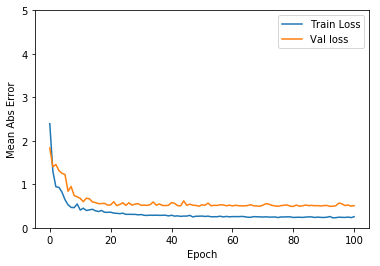

In [16]:
plot_history(history)

In [17]:
result = model.predict(X_test, batch_size=32)
rmse(result, y_test)

0.6604633181447641

## Results

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Early stopping callback
    - Test split of 0.2
    - Using AdamOptimizer gives best results.
    - No cross validation.
    
Network size :
- $4*64 + 1 = 257$ neurons (biases)
- $30049*64 + 64*64 + 64*64 + 64 = 1931392$ weights
- Total of $1931649$ learnable parameters (almost 2 millions)

With the above, we reached a RMSE of 0.5. But this is without separating the data into train and test set. This can lead to overfitting. Now we need to ensure that we are not overfitting.

For this we will test 2 solutions :

### Change our implementation to add regulizer that will avoid this overfitting

### Cross validation over multiple models

# Multi neural network approach

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [6]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

In [7]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [12]:
crowd01 = crowd.Crowd(X_train_red, y_train, "Crowd01")
crowd01.restore()

Recovered 20 entities from session/Crowd01/20


In [23]:
crowd01.train_new_entities(4)

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24160/24339 [============================>.] - ETA: 0s - loss: 31.2337 - mean_absolute_error: 2.9543
Epoch 00001: saving model to session/Crowd01/16
24339/24339 [==============================] - 8s 310us/step - loss: 31.1038 - mean_absolute_error: 2.9459 - val_loss: 13.1879 - val_mean_absolute_error: 1.7464
Epoch 2/200
24192/24339 [============================>.] - ETA: 0s - loss: 10.5435 - mean_absolute_error: 1.4144
Epoch 00002: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 225us/step - loss: 10.5296 - mean_absolute_error: 1.4122 - val_loss: 7.5137 - val_mean_absolute_error: 0.9370
Epoch 3/200
24288/24339 [============================>.] - ETA: 0s - loss: 6.2404 - mean_absolute_error: 0.7555
Epoch 00003: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 200us/step - loss: 6.2390 - mean_absolute_error: 0.7556 - val_loss: 6.1505 - val_mean_absolute_err

Epoch 27/200
24064/24339 [============================>.] - ETA: 0s - loss: 0.6519 - mean_absolute_error: 0.4217
Epoch 00027: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 199us/step - loss: 0.6515 - mean_absolute_error: 0.4214 - val_loss: 0.7188 - val_mean_absolute_error: 0.4608
Epoch 28/200
24128/24339 [============================>.] - ETA: 0s - loss: 0.6490 - mean_absolute_error: 0.4237
Epoch 00028: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 198us/step - loss: 0.6492 - mean_absolute_error: 0.4238 - val_loss: 0.7281 - val_mean_absolute_error: 0.4754
Epoch 29/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.6183 - mean_absolute_error: 0.4108
Epoch 00029: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 198us/step - loss: 0.6187 - mean_absolute_error: 0.4110 - val_loss: 0.8310 - val_mean_absolute_error: 0.5362
Epoch 30/200
24064/24339 [==============

Epoch 53/200
24064/24339 [============================>.] - ETA: 0s - loss: 0.5405 - mean_absolute_error: 0.3906
Epoch 00053: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 199us/step - loss: 0.5400 - mean_absolute_error: 0.3905 - val_loss: 0.5886 - val_mean_absolute_error: 0.4145
Epoch 54/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.5262 - mean_absolute_error: 0.3812
Epoch 00054: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 199us/step - loss: 0.5259 - mean_absolute_error: 0.3813 - val_loss: 0.6033 - val_mean_absolute_error: 0.4301
Epoch 55/200
24288/24339 [============================>.] - ETA: 0s - loss: 0.5263 - mean_absolute_error: 0.3911
Epoch 00055: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 199us/step - loss: 0.5263 - mean_absolute_error: 0.3912 - val_loss: 0.6185 - val_mean_absolute_error: 0.4453
Epoch 56/200
24192/24339 [==============

Epoch 79/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.5012 - mean_absolute_error: 0.3793
Epoch 00079: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 198us/step - loss: 0.5012 - mean_absolute_error: 0.3793 - val_loss: 0.6749 - val_mean_absolute_error: 0.4879
Epoch 80/200
24096/24339 [============================>.] - ETA: 0s - loss: 0.5217 - mean_absolute_error: 0.3877
Epoch 00080: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 199us/step - loss: 0.5217 - mean_absolute_error: 0.3876 - val_loss: 0.6106 - val_mean_absolute_error: 0.4264
Epoch 81/200
24128/24339 [============================>.] - ETA: 0s - loss: 0.5161 - mean_absolute_error: 0.3840
Epoch 00081: saving model to session/Crowd01/16
24339/24339 [==============================] - 5s 198us/step - loss: 0.5165 - mean_absolute_error: 0.3842 - val_loss: 0.6400 - val_mean_absolute_error: 0.4644
Epoch 82/200
24128/24339 [==============

Epoch 11/200
24256/24339 [============================>.] - ETA: 0s - loss: 1.2283 - mean_absolute_error: 0.5093
Epoch 00011: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 1.2282 - mean_absolute_error: 0.5092 - val_loss: 1.1727 - val_mean_absolute_error: 0.4856
Epoch 12/200
24064/24339 [============================>.] - ETA: 0s - loss: 1.1756 - mean_absolute_error: 0.5188
Epoch 00012: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 1.1754 - mean_absolute_error: 0.5189 - val_loss: 1.1584 - val_mean_absolute_error: 0.5100
Epoch 13/200
24320/24339 [============================>.] - ETA: 0s - loss: 1.0997 - mean_absolute_error: 0.5141
Epoch 00013: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 1.0995 - mean_absolute_error: 0.5140 - val_loss: 1.0821 - val_mean_absolute_error: 0.4978
Epoch 14/200
24064/24339 [==============

Epoch 37/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.5967 - mean_absolute_error: 0.4198
Epoch 00037: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 0.5972 - mean_absolute_error: 0.4200 - val_loss: 0.6552 - val_mean_absolute_error: 0.4516
Epoch 38/200
24224/24339 [============================>.] - ETA: 0s - loss: 0.5697 - mean_absolute_error: 0.4013
Epoch 00038: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 0.5696 - mean_absolute_error: 0.4012 - val_loss: 0.6285 - val_mean_absolute_error: 0.4297
Epoch 39/200
24288/24339 [============================>.] - ETA: 0s - loss: 0.5877 - mean_absolute_error: 0.4094
Epoch 00039: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 0.5882 - mean_absolute_error: 0.4098 - val_loss: 0.6645 - val_mean_absolute_error: 0.4494
Epoch 40/200
24128/24339 [==============

Epoch 63/200
24064/24339 [============================>.] - ETA: 0s - loss: 0.5352 - mean_absolute_error: 0.3916
Epoch 00063: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 0.5354 - mean_absolute_error: 0.3915 - val_loss: 0.5899 - val_mean_absolute_error: 0.4165
Epoch 64/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.5512 - mean_absolute_error: 0.3984
Epoch 00064: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 0.5510 - mean_absolute_error: 0.3983 - val_loss: 0.6253 - val_mean_absolute_error: 0.4255
Epoch 65/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.5482 - mean_absolute_error: 0.4006
Epoch 00065: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 0.5482 - mean_absolute_error: 0.4006 - val_loss: 0.6038 - val_mean_absolute_error: 0.4250
Epoch 66/200
24064/24339 [==============

Epoch 89/200
24064/24339 [============================>.] - ETA: 0s - loss: 0.5208 - mean_absolute_error: 0.3872
Epoch 00089: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 0.5203 - mean_absolute_error: 0.3869 - val_loss: 0.5835 - val_mean_absolute_error: 0.4125
Epoch 90/200
24320/24339 [============================>.] - ETA: 0s - loss: 0.5213 - mean_absolute_error: 0.3849
Epoch 00090: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 0.5213 - mean_absolute_error: 0.3849 - val_loss: 0.5595 - val_mean_absolute_error: 0.4127
Epoch 91/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.5283 - mean_absolute_error: 0.3912
Epoch 00091: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 0.5282 - mean_absolute_error: 0.3911 - val_loss: 0.5791 - val_mean_absolute_error: 0.4113
Epoch 92/200
24096/24339 [==============

Epoch 115/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.4987 - mean_absolute_error: 0.3814
Epoch 00115: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 203us/step - loss: 0.4989 - mean_absolute_error: 0.3816 - val_loss: 0.5741 - val_mean_absolute_error: 0.4295
Epoch 116/200
24320/24339 [============================>.] - ETA: 0s - loss: 0.5167 - mean_absolute_error: 0.3870
Epoch 00116: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 219us/step - loss: 0.5167 - mean_absolute_error: 0.3871 - val_loss: 0.5426 - val_mean_absolute_error: 0.4047
Epoch 117/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.4877 - mean_absolute_error: 0.3725
Epoch 00117: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 207us/step - loss: 0.4877 - mean_absolute_error: 0.3725 - val_loss: 0.5874 - val_mean_absolute_error: 0.4318
Epoch 118/200
24192/24339 [==========

Epoch 141/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.5001 - mean_absolute_error: 0.3781
Epoch 00141: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 0.5006 - mean_absolute_error: 0.3784 - val_loss: 0.5545 - val_mean_absolute_error: 0.4136
Epoch 142/200
24064/24339 [============================>.] - ETA: 0s - loss: 0.4842 - mean_absolute_error: 0.3713
Epoch 00142: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 204us/step - loss: 0.4849 - mean_absolute_error: 0.3716 - val_loss: 0.6401 - val_mean_absolute_error: 0.4753
Epoch 143/200
24064/24339 [============================>.] - ETA: 0s - loss: 0.4855 - mean_absolute_error: 0.3751
Epoch 00143: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 205us/step - loss: 0.4857 - mean_absolute_error: 0.3751 - val_loss: 0.5448 - val_mean_absolute_error: 0.4152
Epoch 144/200
24192/24339 [==========

Epoch 167/200
24288/24339 [============================>.] - ETA: 0s - loss: 0.4884 - mean_absolute_error: 0.3764
Epoch 00167: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 219us/step - loss: 0.4885 - mean_absolute_error: 0.3765 - val_loss: 0.5624 - val_mean_absolute_error: 0.4240
Epoch 168/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.4715 - mean_absolute_error: 0.3689
Epoch 00168: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 221us/step - loss: 0.4714 - mean_absolute_error: 0.3688 - val_loss: 0.5448 - val_mean_absolute_error: 0.4123
Epoch 169/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.4660 - mean_absolute_error: 0.3708
Epoch 00169: saving model to session/Crowd01/17
24339/24339 [==============================] - 5s 221us/step - loss: 0.4660 - mean_absolute_error: 0.3708 - val_loss: 0.5371 - val_mean_absolute_error: 0.4143
Epoch 170/200
24192/24339 [==========

Epoch 14/200
24288/24339 [============================>.] - ETA: 0s - loss: 1.1106 - mean_absolute_error: 0.5235
Epoch 00014: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 228us/step - loss: 1.1105 - mean_absolute_error: 0.5235 - val_loss: 1.2407 - val_mean_absolute_error: 0.6002
Epoch 15/200
24224/24339 [============================>.] - ETA: 0s - loss: 1.0208 - mean_absolute_error: 0.4895
Epoch 00015: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 226us/step - loss: 1.0214 - mean_absolute_error: 0.4896 - val_loss: 1.0386 - val_mean_absolute_error: 0.4717
Epoch 16/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.9794 - mean_absolute_error: 0.4784
Epoch 00016: saving model to session/Crowd01/18
24339/24339 [==============================] - 5s 226us/step - loss: 0.9795 - mean_absolute_error: 0.4786 - val_loss: 0.9525 - val_mean_absolute_error: 0.4677
Epoch 17/200
24160/24339 [==============

Epoch 40/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.5828 - mean_absolute_error: 0.4052
Epoch 00040: saving model to session/Crowd01/18
24339/24339 [==============================] - 5s 226us/step - loss: 0.5830 - mean_absolute_error: 0.4054 - val_loss: 0.6468 - val_mean_absolute_error: 0.4253
Epoch 41/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.5755 - mean_absolute_error: 0.4014
Epoch 00041: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 227us/step - loss: 0.5755 - mean_absolute_error: 0.4014 - val_loss: 0.6561 - val_mean_absolute_error: 0.4314
Epoch 42/200
24256/24339 [============================>.] - ETA: 0s - loss: 0.5787 - mean_absolute_error: 0.4066
Epoch 00042: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 227us/step - loss: 0.5785 - mean_absolute_error: 0.4064 - val_loss: 0.6484 - val_mean_absolute_error: 0.4264
Epoch 43/200
24128/24339 [==============

Epoch 66/200
24224/24339 [============================>.] - ETA: 0s - loss: 0.5367 - mean_absolute_error: 0.3886
Epoch 00066: saving model to session/Crowd01/18
24339/24339 [==============================] - 5s 224us/step - loss: 0.5371 - mean_absolute_error: 0.3887 - val_loss: 0.6251 - val_mean_absolute_error: 0.4368
Epoch 67/200
24288/24339 [============================>.] - ETA: 0s - loss: 0.5567 - mean_absolute_error: 0.4015
Epoch 00067: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 227us/step - loss: 0.5570 - mean_absolute_error: 0.4017 - val_loss: 0.6024 - val_mean_absolute_error: 0.4155
Epoch 68/200
24288/24339 [============================>.] - ETA: 0s - loss: 0.5393 - mean_absolute_error: 0.3840
Epoch 00068: saving model to session/Crowd01/18
24339/24339 [==============================] - 5s 226us/step - loss: 0.5394 - mean_absolute_error: 0.3842 - val_loss: 0.6322 - val_mean_absolute_error: 0.4330
Epoch 69/200
24320/24339 [==============

Epoch 92/200
24320/24339 [============================>.] - ETA: 0s - loss: 0.5206 - mean_absolute_error: 0.3867
Epoch 00092: saving model to session/Crowd01/18
24339/24339 [==============================] - 5s 225us/step - loss: 0.5206 - mean_absolute_error: 0.3867 - val_loss: 0.6553 - val_mean_absolute_error: 0.4829
Epoch 93/200
24224/24339 [============================>.] - ETA: 0s - loss: 0.5100 - mean_absolute_error: 0.3759
Epoch 00093: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 226us/step - loss: 0.5100 - mean_absolute_error: 0.3759 - val_loss: 0.6086 - val_mean_absolute_error: 0.4426
Epoch 94/200
24096/24339 [============================>.] - ETA: 0s - loss: 0.5007 - mean_absolute_error: 0.3768
Epoch 00094: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 227us/step - loss: 0.5012 - mean_absolute_error: 0.3769 - val_loss: 0.5805 - val_mean_absolute_error: 0.4125
Epoch 95/200
24256/24339 [==============

Epoch 118/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.5004 - mean_absolute_error: 0.3763
Epoch 00118: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 226us/step - loss: 0.5008 - mean_absolute_error: 0.3765 - val_loss: 0.5604 - val_mean_absolute_error: 0.4118
Epoch 119/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.4948 - mean_absolute_error: 0.3706
Epoch 00119: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 227us/step - loss: 0.4947 - mean_absolute_error: 0.3704 - val_loss: 0.5436 - val_mean_absolute_error: 0.3986
Epoch 120/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.4971 - mean_absolute_error: 0.3751
Epoch 00120: saving model to session/Crowd01/18
24339/24339 [==============================] - 6s 226us/step - loss: 0.4978 - mean_absolute_error: 0.3755 - val_loss: 0.6859 - val_mean_absolute_error: 0.5163
Epoch 121/200
24256/24339 [==========

Epoch 5/200
24128/24339 [============================>.] - ETA: 0s - loss: 3.9242 - mean_absolute_error: 0.5627
Epoch 00005: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 231us/step - loss: 3.9201 - mean_absolute_error: 0.5625 - val_loss: 3.5432 - val_mean_absolute_error: 0.5624
Epoch 6/200
24256/24339 [============================>.] - ETA: 0s - loss: 3.0442 - mean_absolute_error: 0.5143
Epoch 00006: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 230us/step - loss: 3.0428 - mean_absolute_error: 0.5143 - val_loss: 2.7840 - val_mean_absolute_error: 0.5578
Epoch 7/200
24128/24339 [============================>.] - ETA: 0s - loss: 2.4050 - mean_absolute_error: 0.5143
Epoch 00007: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 231us/step - loss: 2.4058 - mean_absolute_error: 0.5150 - val_loss: 2.3214 - val_mean_absolute_error: 0.6273
Epoch 8/200
24192/24339 [==================

Epoch 31/200
24320/24339 [============================>.] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.4176
Epoch 00031: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 232us/step - loss: 0.6277 - mean_absolute_error: 0.4175 - val_loss: 0.6916 - val_mean_absolute_error: 0.4429
Epoch 32/200
24128/24339 [============================>.] - ETA: 0s - loss: 0.6022 - mean_absolute_error: 0.4076
Epoch 00032: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 230us/step - loss: 0.6028 - mean_absolute_error: 0.4081 - val_loss: 0.6474 - val_mean_absolute_error: 0.4222
Epoch 33/200
24288/24339 [============================>.] - ETA: 0s - loss: 0.6032 - mean_absolute_error: 0.4078
Epoch 00033: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 233us/step - loss: 0.6031 - mean_absolute_error: 0.4078 - val_loss: 0.6979 - val_mean_absolute_error: 0.4799
Epoch 34/200
24192/24339 [==============

Epoch 57/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.5459 - mean_absolute_error: 0.3960
Epoch 00057: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 232us/step - loss: 0.5458 - mean_absolute_error: 0.3960 - val_loss: 0.5627 - val_mean_absolute_error: 0.3988
Epoch 58/200
24096/24339 [============================>.] - ETA: 0s - loss: 0.5511 - mean_absolute_error: 0.4033
Epoch 00058: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 233us/step - loss: 0.5505 - mean_absolute_error: 0.4029 - val_loss: 0.6091 - val_mean_absolute_error: 0.4286
Epoch 59/200
24160/24339 [============================>.] - ETA: 0s - loss: 0.5481 - mean_absolute_error: 0.4008
Epoch 00059: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 232us/step - loss: 0.5487 - mean_absolute_error: 0.4010 - val_loss: 0.6818 - val_mean_absolute_error: 0.4888
Epoch 60/200
24128/24339 [==============

Epoch 83/200
24192/24339 [============================>.] - ETA: 0s - loss: 0.5075 - mean_absolute_error: 0.3823
Epoch 00083: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 233us/step - loss: 0.5074 - mean_absolute_error: 0.3823 - val_loss: 0.5626 - val_mean_absolute_error: 0.4147
Epoch 84/200
24096/24339 [============================>.] - ETA: 0s - loss: 0.5203 - mean_absolute_error: 0.3911
Epoch 00084: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 233us/step - loss: 0.5208 - mean_absolute_error: 0.3911 - val_loss: 0.5981 - val_mean_absolute_error: 0.4430
Epoch 85/200
24224/24339 [============================>.] - ETA: 0s - loss: 0.5176 - mean_absolute_error: 0.3893
Epoch 00085: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 234us/step - loss: 0.5177 - mean_absolute_error: 0.3894 - val_loss: 0.5766 - val_mean_absolute_error: 0.4236
Epoch 86/200
24256/24339 [==============

Epoch 109/200
24224/24339 [============================>.] - ETA: 0s - loss: 0.4976 - mean_absolute_error: 0.3807
Epoch 00109: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 231us/step - loss: 0.4976 - mean_absolute_error: 0.3808 - val_loss: 0.5911 - val_mean_absolute_error: 0.4491
Epoch 110/200
24224/24339 [============================>.] - ETA: 0s - loss: 0.5005 - mean_absolute_error: 0.3843
Epoch 00110: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 233us/step - loss: 0.5003 - mean_absolute_error: 0.3841 - val_loss: 0.5604 - val_mean_absolute_error: 0.4144
Epoch 111/200
24320/24339 [============================>.] - ETA: 0s - loss: 0.5142 - mean_absolute_error: 0.3908
Epoch 00111: saving model to session/Crowd01/19
24339/24339 [==============================] - 6s 232us/step - loss: 0.5142 - mean_absolute_error: 0.3908 - val_loss: 0.5500 - val_mean_absolute_error: 0.4055
Epoch 112/200
24256/24339 [==========

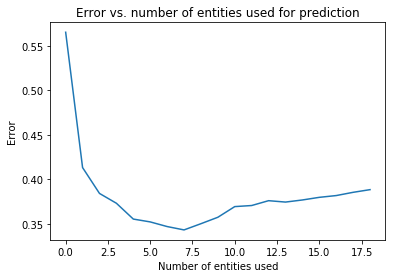

In [25]:
crowd01.plot_crowd_error(X_test_red, y_test, rmse)

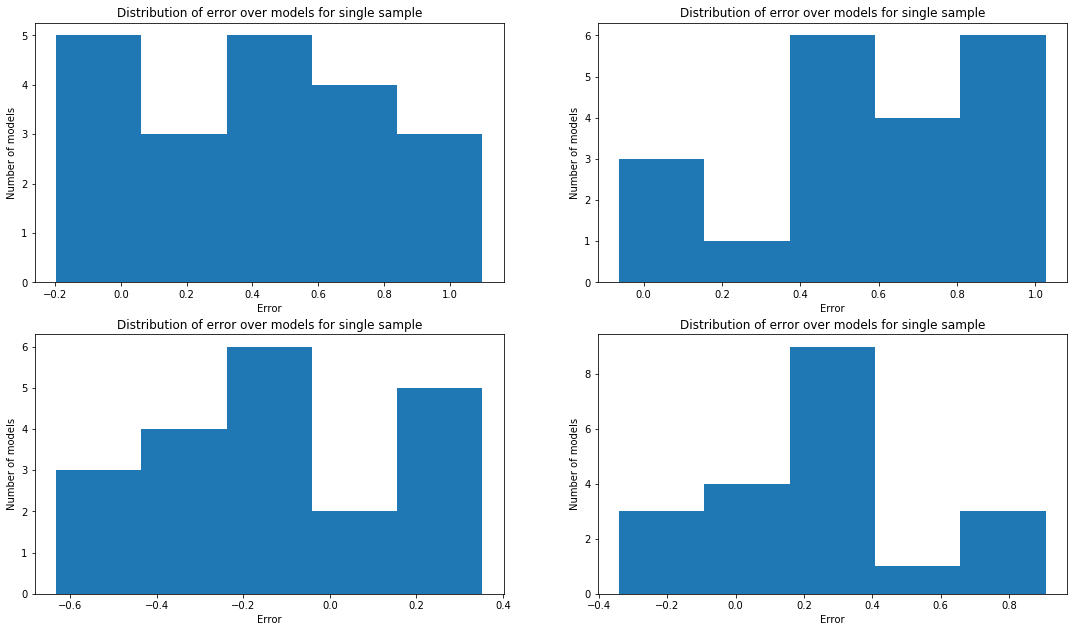

In [17]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.subplot(221)
crowd01.plot_error_dist_on_sample(X_test_red[0], y_test[0], basic_error, show = False)
plt.subplot(222)
crowd01.plot_error_dist_on_sample(X_test_red[1], y_test[1], basic_error, show = False)
plt.subplot(223)
crowd01.plot_error_dist_on_sample(X_test_red[2], y_test[2], basic_error, show = False)
plt.subplot(224)
crowd01.plot_error_dist_on_sample(X_test_red[3], y_test[3], basic_error, show = False)
plt.show()

In [10]:
rmse(crowd01.predict(X_test_red), y_test)

0.3197507002101804

## Results
The results are good, however we remark a bias which has to be corrected using other networks in the crowd (of other type maybe).

# Trying Dropout layers
Dropout layers have been reported in the litterature to bring good results to avoid overfitting in combination with L2 regularizers http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf (Srivastava et al.). It will train the model while keeping only a neuron active with probability p.

In [12]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Assuming each layer represent a link between particules, we begin with 4 layers
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    tf.layers.dropout(64, rate=0.1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.5)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

TypeError: dropout() got an unexpected keyword argument 'activation'

In [ ]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 100
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.2
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

In [ ]:
plot_history(history)

#  Feature selection matrix

In [6]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [7]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_train_red = X_red[: train_set_size]
X_test_red = X_red[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [8]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [9]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [10]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 21s 882us/step - loss: 16.2423 - mean_absolute_error: 2.7712 - val_loss: 11.7952 - val_mean_absolute_error: 2.7973
Epoch 2/200
24339/24339 [==============================] - 20s 823us/step - loss: 2.7857 - mean_absolute_error: 1.0994 - val_loss: 2.2373 - val_mean_absolute_error: 0.9991
Epoch 3/200
24339/24339 [==============================] - 20s 836us/step - loss: 0.8024 - mean_absolute_error: 0.4852 - val_loss: 1.8001 - val_mean_absolute_error: 0.8622
Epoch 4/200
24339/24339 [==============================] - 21s 855us/step - loss: 0.6898 - mean_absolute_error: 0.4331 - val_loss: 1.5499 - val_mean_absolute_error: 0.7983
Epoch 5/200
24339/24339 [==============================] - 20s 808us/step - loss: 0.7234 - mean_absolute_error: 0.4703 - val_loss: 1.5848 - val_mean_absolute_error: 0.8310
Epoch 6/200
24339/24339 [==============================] - 19s 799us/step - loss: 0.7371 

24339/24339 [==============================] - 21s 851us/step - loss: 0.1102 - mean_absolute_error: 0.1804 - val_loss: 0.6129 - val_mean_absolute_error: 0.5024
Epoch 96/200
24339/24339 [==============================] - 20s 839us/step - loss: 0.1113 - mean_absolute_error: 0.1835 - val_loss: 0.6052 - val_mean_absolute_error: 0.4992
Epoch 97/200
24339/24339 [==============================] - 21s 848us/step - loss: 0.1150 - mean_absolute_error: 0.1902 - val_loss: 0.6312 - val_mean_absolute_error: 0.5190
Epoch 98/200
24339/24339 [==============================] - 21s 849us/step - loss: 0.1101 - mean_absolute_error: 0.1823 - val_loss: 0.6291 - val_mean_absolute_error: 0.5101
Epoch 99/200
24339/24339 [==============================] - 21s 849us/step - loss: 0.1202 - mean_absolute_error: 0.1958 - val_loss: 0.6232 - val_mean_absolute_error: 0.5087
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)   

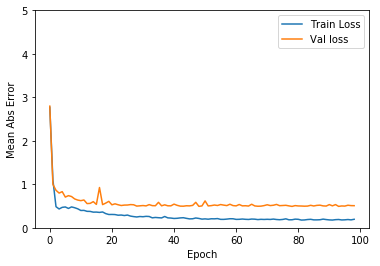

In [11]:
plot_history(history)

In [12]:
result = model.predict(X_test_red, batch_size=32)
rmse(result, y_test)

0.6834309411311952

# Verification of feature selection matrix - polynomial expansion

In [9]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [10]:
X_red.shape

(30049, 3004)

In [13]:
X_poly = build_poly(X_red, 2)

In [14]:
X_poly.shape

(30049, 6008)

In [15]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)
X_poly_train_red = X_poly[: train_set_size]
X_poly_test_red = X_poly[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [16]:
print("X_poly_red: " + str(X_poly.shape))
print("y: " + str(y.shape))

X_poly_red: (30049, 6008)
y: (30049,)


In [18]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [19]:
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_poly_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 15s 609us/step - loss: 68.8399 - mean_absolute_error: 5.7557 - val_loss: 27.8898 - val_mean_absolute_error: 3.7220
Epoch 2/200
24339/24339 [==============================] - 12s 498us/step - loss: 6.5372 - mean_absolute_error: 1.8642 - val_loss: 18.6232 - val_mean_absolute_error: 2.6665
Epoch 3/200
24339/24339 [==============================] - 12s 502us/step - loss: 2.9390 - mean_absolute_error: 1.2613 - val_loss: 13.8524 - val_mean_absolute_error: 2.5427
Epoch 4/200
24339/24339 [==============================] - 12s 504us/step - loss: 2.3184 - mean_absolute_error: 1.1061 - val_loss: 16.8185 - val_mean_absolute_error: 2.3774
Epoch 5/200
24339/24339 [==============================] - 12s 508us/step - loss: 2.9168 - mean_absolute_error: 1.1900 - val_loss: 16.8111 - val_mean_absolute_error: 3.0914
Epoch 6/200
24339/24339 [==============================] - 12s 512us/step - loss: 4.4

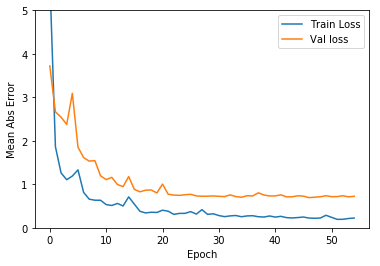

In [20]:
plot_history(history)

In [21]:
result = model.predict(X_poly_test_red, batch_size=32)
rmse(result, y_test)

1.0123385147545783